In [1]:
#%run ../Exploring_data/Exploratory_analysis.ipynb

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv('./final_dataframe.csv',index_col='datetime')

It is important to considerar the time that we want to predict. If we want to know the price for 1 week, we will need to shift the target column 7 days so, with the information we have today, we can predict the value for the electricity in 7 days:

In [3]:
df = pd.concat([df,pd.get_dummies(df['Weekday'], prefix='Weekday')],axis=1)
df = pd.concat([df,pd.get_dummies(df['Hour'], prefix='Hour')],axis=1)
# now drop the original 'Weekday' column (you don't need it anymore)
df.drop(['Weekday','Hour'],axis=1, inplace=True)

In [4]:
#Queremos adivinarlo con 7 días de antelacion: 7x24 = 168
df['Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']=df['Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)'].shift(-168)

In [5]:
df.dropna(axis=0,how='any',inplace=True)

In [6]:
model_columns = ['Demanda_programada_P48_total', 'Precio_mercado_SPOT_Diario','Precio_mercado_SPOT_Intradiario_Sesion_1',
       'Precio_mercado_SPOT_Intradiario_Sesion_2',
       'Demanda_programada_P48_Correccion_eolica',
       'Demanda_programada_P48_Correccion_solar',
       'Generacion_programada_P48_Biogas', 'Generacion_programada_P48_Biomasa',
       'Generacion_programada_P48_Ciclo_combinado',
       'Generacion_programada_P48_Consumo_bombeo',
       'Generacion_programada_P48_Derivados_del_petroleo_o_carbon',
       'Generacion_programada_P48_Energia_residual',
       'Generacion_programada_P48_Enlace_Baleares',
       'Generacion_programada_P48_Eolica_terrestre',
       'Generacion_programada_P48_Gas_Natural',
       'Generacion_programada_P48_Gas_Natural_Cogeneracion',
       'Generacion_programada_P48_Hidraulica_UGH',
       'Generacion_programada_P48_Hidraulica_no_UGH',
       'Generacion_programada_P48_Hulla_antracita',
       'Generacion_programada_P48_Hulla_sub-bituminosa',
       'Generacion_programada_P48_Nuclear',
       'Generacion_programada_P48_Oceano_y_geotermica',
       'Generacion_programada_P48_Residuos_domesticos_y_similares',
       'Generacion_programada_P48_Residuos_varios',
       'Generacion_programada_P48_Solar_fotovoltaica',
       'Generacion_programada_P48_Solar_termica',
       'Generacion_programada_P48_Subproductos_mineria',
       'Generacion_programada_P48_Turbinacion_bombeo', 'holidays',
       'Weekday_Friday', 'Weekday_Monday',
       'Weekday_Saturday', 'Weekday_Sunday', 'Weekday_Thursday',
       'Weekday_Tuesday', 'Weekday_Wednesday', 'Hour_0', 'Hour_1', 'Hour_2',
       'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9',
       'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15',
       'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21',
       'Hour_22', 'Hour_23']

In [7]:
X = df.loc[:,model_columns]
y = df.loc[:,'Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']
y_train = df.loc[:'2020-01-01 00:00:00+00:00','Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']
X_train = df.loc[:'2020-01-01 00:00:00+00:00',model_columns]
y_test = df.loc['2020-01-01 00:00:00+00:00':,'Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']
X_test = df.loc['2020-01-01 00:00:00+00:00':,model_columns]

In [8]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 20, n_estimators = 40)

parameters = {'colsample_bytree':[0.4,0.35,0.3,0.25,0.2],'learning_rate': [0.1,0.15,0.18,0.2],
                'max_depth': [5,6,8]}

xgb_mod = GridSearchCV(xg_reg,cv=10,param_grid=parameters,scoring='neg_mean_squared_error')

In [9]:
xgb_mod.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=XGBRegressor(alpha=20, base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.3,
                                    gamma=None, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=5, min_child_weight=None,
                                    missing=nan, monotone_cons...
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    validate_parameters=False, verbosity=None),
             iid='warn', n_jobs=None,
             param_grid={'colsample_bytree': [0.4, 0.35, 0.3, 0.

In [10]:
xgb_mod.best_estimator_.fit(X_train,y_train)

XGBRegressor(alpha=20, base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.2, max_delta_step=0, max_depth=8,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=40, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=20,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [13]:
np.sqrt(abs(xgb_mod.best_score_))

12.384747655187555

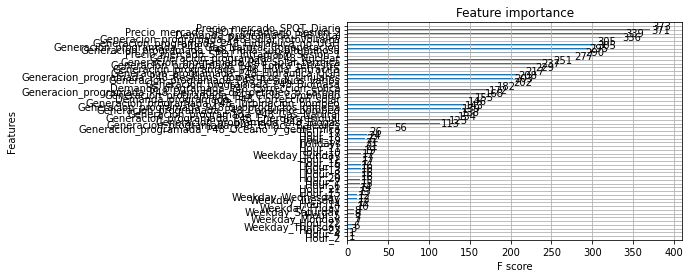

In [12]:
xgb.plot_importance(xgb_mod.best_estimator_)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()